In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

dataset = pd.read_csv("lung_cancer_dataset.csv")

# Convert text to categorical data
dataset['gender'] = dataset['gender'].astype('category')
dataset['radon_exposure'] = dataset['radon_exposure'].astype('category')
dataset['alcohol_consumption'] = dataset['alcohol_consumption'].fillna('None').astype('category')

dataset['asbestos_exposure'] = dataset['asbestos_exposure'].map({'Yes': True, 'No': False})
dataset['secondhand_smoke_exposure'] = dataset['secondhand_smoke_exposure'].map({'Yes': True, 'No': False})
dataset['copd_diagnosis'] = dataset['copd_diagnosis'].map({'Yes': True, 'No': False})
dataset['family_history'] = dataset['family_history'].map({'Yes': True, 'No': False})
dataset['lung_cancer'] = dataset['lung_cancer'].map({'Yes': True, 'No': False})

# get the data and target from the data frame 
data = dataset.loc[:, 'age':'family_history']
target = dataset['lung_cancer']

train_data, test_data, train_label, test_label = train_test_split(data, target, test_size=0.3, random_state=0)

# Spaltennamen nach Typ trennen
categorical_cols = data.select_dtypes(include=['category']).columns.tolist()
numeric_cols = data.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder)
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_cols), # RobustScaler() hat keine/kaum Auswirkung
    ("cat", OneHotEncoder(drop='first'), categorical_cols)
])

X_processed = preprocessor.fit_transform(train_data)

In [2]:
# uv add xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Initialize the XGBoost Classifier
# Since your 'lung_cancer' target is binary (True/False), you'll use an XGBClassifier.
# 'objective': 'binary:logistic' is standard for binary classification.
# 'use_label_encoder': False is recommended to avoid a deprecation warning.
# 'eval_metric': 'logloss' is a common metric for binary problems.
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42 # for reproducibility
)

# 2. Train the Model
# Fit the model using your processed training data (X_processed) and training labels (train_label).
print("Starting model training...")
xgb_model.fit(X_processed, train_label)
print("Model training complete.")

# 4. Make Predictions
# Predict the probabilities for the positive class (True/1)
X_test_processed = preprocessor.transform(test_data)
y_pred_proba = xgb_model.predict_proba(X_test_processed)[:, 1]

# Convert probabilities to binary predictions (True/False or 1/0)
# A threshold of 0.5 is standard.
y_pred = (y_pred_proba >= 0.5)

# 5. Evaluate the Model
print("\n--- Model Evaluation ---")

# a. Accuracy
accuracy = accuracy_score(test_label, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# b. Confusion Matrix
conf_matrix = confusion_matrix(test_label, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# c. Classification Report (includes Precision, Recall, F1-Score)
class_report = classification_report(test_label, y_pred, target_names=['No Cancer', 'Cancer'])
print("\nClassification Report:")
print(class_report)

Starting model training...


/workspaces/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:28:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

--- Model Evaluation ---
Accuracy: 0.7277

Confusion Matrix:
[[1879 2802]
 [1282 9037]]

Classification Report:
              precision    recall  f1-score   support

   No Cancer       0.59      0.40      0.48      4681
      Cancer       0.76      0.88      0.82     10319

    accuracy                           0.73     15000
   macro avg       0.68      0.64      0.65     15000
weighted avg       0.71      0.73      0.71     15000



In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# --- 1. Hyperparameter Tuning using HalvingSearchCV ---

# Since the dataset is imbalanced, we will use 'f1_weighted' as the scoring metric 
# to balance Precision and Recall across both classes.
print("\n--- Hyperparameter Tuning (Halving Search) ---")

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200], # Number of boosting rounds
    'max_depth': [3, 5, 7],         # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2] # Step size shrinkage
}

# Initialize the base XGBoost Classifier
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Initialize HalvingRandomSearchCV
random_halving_search = HalvingRandomSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    factor=2,                      # Resources increase by a factor of 2 at each stage (default)
    scoring='f1_weighted',         # Use weighted F1-score due to class imbalance
    cv=3,                          # 3-fold cross-validation
    verbose=0,
    random_state=42,
    n_jobs=-1                      # Use all available cores
)

# Execute the halving search on the training data
print("Starting Halving Random Search...")
random_halving_search.fit(X_processed, train_label)
print("Halving Random Search complete.")

# Get the best model
best_xgb_model = random_halving_search.best_estimator_
print(f"Best parameters found: {random_halving_search.best_params_}")

# --- 2. Predict and Evaluate with the BEST Tuned Model ---

print("\n--- Evaluation of BEST Tuned Model ---")

# Make Predictions with the best model
y_pred_tuned = best_xgb_model.predict(X_test_processed)

# a. Accuracy
accuracy_tuned = accuracy_score(test_label, y_pred_tuned)
print(f"Tuned Model Accuracy: {accuracy_tuned:.4f}")

# b. Confusion Matrix
conf_matrix_tuned = confusion_matrix(test_label, y_pred_tuned)
print("\nConfusion Matrix (Tuned Model):")
print(conf_matrix_tuned)

# c. Classification Report
class_report_tuned = classification_report(test_label, y_pred_tuned, target_names=['No Cancer (False)', 'Cancer (True)'])
print("\nClassification Report (Tuned Model):")
print(class_report_tuned)

# --- 3. Feature Importance ---
# This uses the feature importance from the best-tuned model
print("\n--- Feature Importance (from Tuned Model) ---")

# Get feature names after one-hot encoding
feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Create a Series for easy viewing
feature_importance = pd.Series(best_xgb_model.feature_importances_, index=feature_names)
print("Features sorted by Importance:")
print(feature_importance.sort_values(ascending=False))


--- Hyperparameter Tuning (Halving Search) ---
Starting Halving Random Search...


/workspaces/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=2916. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/workspaces/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:28:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:28:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:28:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/.venv/lib/python3.12/site-packages/xgboost/trai

Halving Random Search complete.
Best parameters found: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2}

--- Evaluation of BEST Tuned Model ---
Tuned Model Accuracy: 0.7443

Confusion Matrix (Tuned Model):
[[1872 2809]
 [1027 9292]]

Classification Report (Tuned Model):
                   precision    recall  f1-score   support

No Cancer (False)       0.65      0.40      0.49      4681
    Cancer (True)       0.77      0.90      0.83     10319

         accuracy                           0.74     15000
        macro avg       0.71      0.65      0.66     15000
     weighted avg       0.73      0.74      0.72     15000


--- Feature Importance (from Tuned Model) ---
Features sorted by Importance:
pack_years                      0.195671
copd_diagnosis                  0.162428
asbestos_exposure               0.147837
family_history                  0.120943
radon_exposure_Low              0.101497
secondhand_smoke_exposure       0.083592
age                             0.0789

Visualisierung

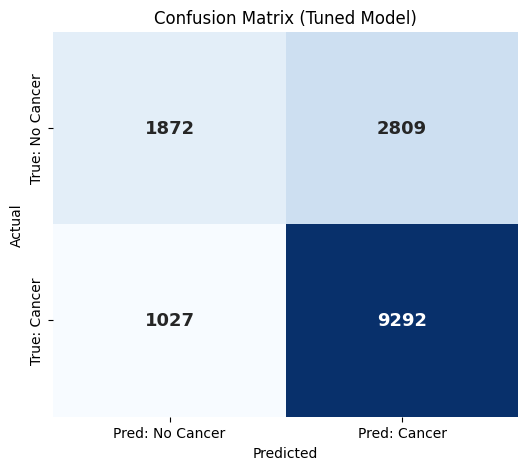

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: No Cancer', 'Pred: Cancer'],
            yticklabels=['True: No Cancer', 'True: Cancer'],
            cbar=False,
            annot_kws={"size": 13, "weight": "bold"})
plt.title("Confusion Matrix (Tuned Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

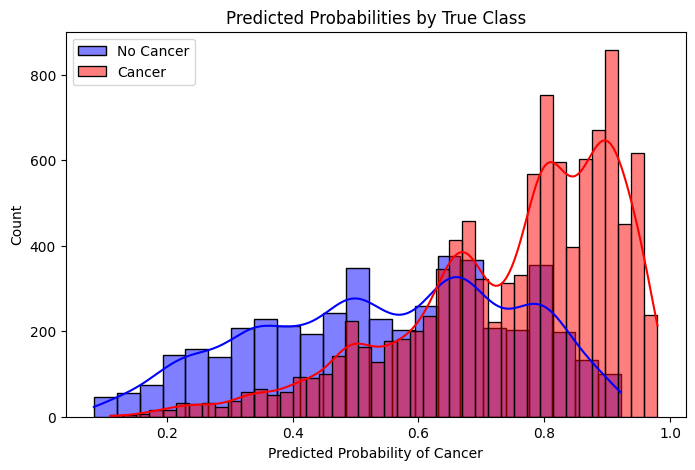

In [5]:
y_proba = best_xgb_model.predict_proba(X_test_processed)[:, 1]

plt.figure(figsize=(8, 5))
sns.histplot(y_proba[test_label == 0], color='blue', label='No Cancer', kde=True)
sns.histplot(y_proba[test_label == 1], color='red', label='Cancer', kde=True)
plt.title("Predicted Probabilities by True Class")
plt.xlabel("Predicted Probability of Cancer")
plt.ylabel("Count")
plt.legend()
plt.show()

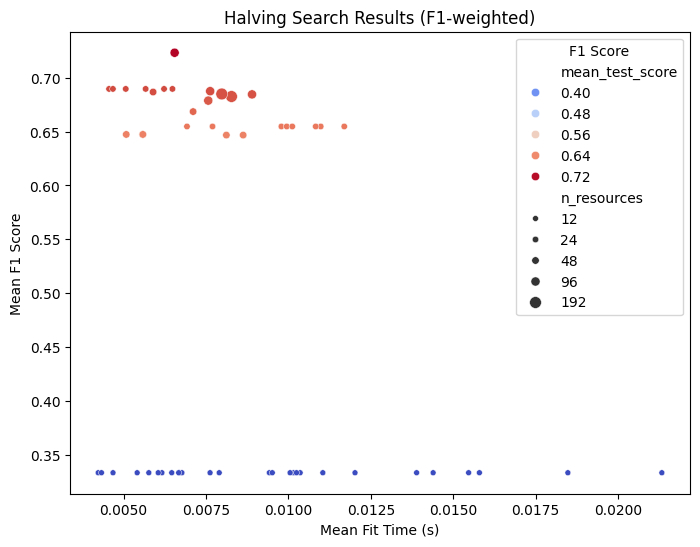

In [6]:
results = pd.DataFrame(random_halving_search.cv_results_)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results, x='mean_fit_time', y='mean_test_score', 
                size='n_resources', hue='mean_test_score', palette='coolwarm')
plt.title("Halving Search Results (F1-weighted)")
plt.xlabel("Mean Fit Time (s)")
plt.ylabel("Mean F1 Score")
plt.legend(title="F1 Score")
plt.show()

/workspaces/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:28:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:28:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:28:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:28:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/.venv/lib/python3.12/site-packages/xgboost/training.py:183: 

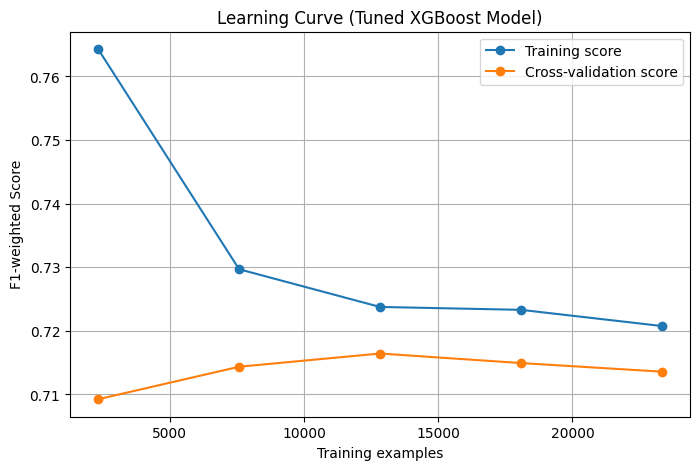

In [7]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_xgb_model, X_processed, train_label, cv=3, scoring='f1_weighted', n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-validation score')
plt.title("Learning Curve (Tuned XGBoost Model)")
plt.xlabel("Training examples")
plt.ylabel("F1-weighted Score")
plt.legend()
plt.grid()
plt.show()